## Titanic with Pandas, TensorFlow and other methods

First, import some useful modules

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # use seaborn, see https://stanford.edu/~mwaskom/software/seaborn/
import re
import pylab
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn
import random

Now, load the training data set into a pandas data frame and see how many records are there

In [2]:
training_df = pd.read_csv("train.csv")
training_df.shape

(891, 12)

Have a quick look at what's in the data - show first 5 rows only

In [3]:
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's extract first names, surnames and titles into additional columns. Note that we use regular expressions.

In [4]:
training_df["First_Name"] = training_df["Name"].apply(lambda _: _.split()[2])
training_df["Surname"] = training_df["Name"].apply(lambda _: _.split(",")[0])
training_df["Title"] = training_df["Name"].apply(lambda _: re.findall(",\s+(\w+)\.",_)[0] if len(re.findall(",\s+(\w+)\.",_)) > 0 else None)

Check that the columns have actually been added

In [5]:
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First_Name,Surname,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Owen,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,John,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Laina,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Jacques,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,William,Allen,Mr


What to do about the missing values? Let's check how manuy of these we've got.

In [6]:
training_df.count()  # this returns the number of non-NA/null observations in each column

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
First_Name     891
Surname        891
Title          890
dtype: int64

Obviously, all looks good. Rerecall that the total number of records is 891, so any variable with less that 891 has some missing values. Apparently, Age is a bit of a problem and Cabin is largely missing values. So, what are these Cabin values? Have a closer look..

In [14]:
training_df["Cabin"].unique()  # unique values in Cabin column

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

Ok, so these are a letter with some number. It would be interesting to have a map of Titanic to see if a particulat letter or set of numbers defines an area of the ship that would seem important in relation to drawning. For example, "D" could mean the top level or, maybe, "B11" to "B34" are cabins in an area difficult to get out from or close/far from the boats.. But we don't have that map right now so it's reasonable to simply ignore the "Cabin" column.

What about Age? We could just set all absent age values to 0 or ignore all records where Age is not available. However, that seems not quite right.. We could assign the mean age of all available records. Or, a more interesting approch is to approcimate the age based on Title. How often do we see records with no age but some title present?

In [18]:
len(training_df[training_df["Age"].isnull() & training_df["Title"].notnull()].index)

177

Not bad. Actually, 714 records have Age (as we noticed before) and if we approximate another 177, we will get all 891 Age values.

We want to keep things simple. Suppose it's Miss (most likely an unmarried woman), then we assign this person age 18.
If it's Mrs, we take say an average between 18 and 60, which is 39. Why 60? Because as we can see from Figure 2 below,
the there weren't many passengers over 60 at all. Regarding the men: let us say that men were 39 on average too, again, based on the figure.

<IPython.core.display.Javascript object>


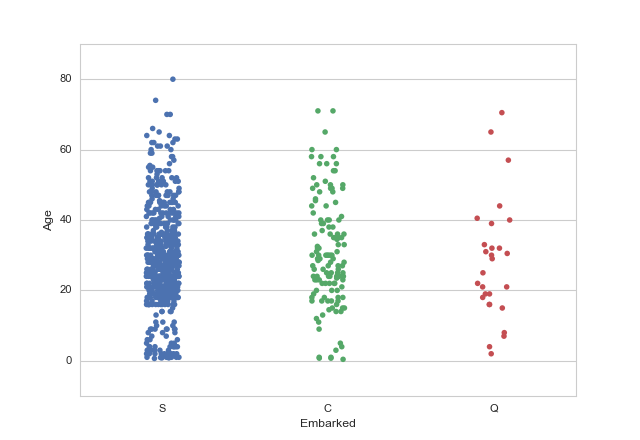

In [10]:
plt.figure()
sns.stripplot(x="Embarked", y="Age", data=training_df, jitter=True);

So, adding the missing Age values as follows.

In [45]:
training_df["Age"] = training_df[training_df["Title"].isin(["Miss","Ms"])]["Age"].fillna(18)
training_df["Age"] = training_df[training_df["Title"].isin(["Mr","Mrs"])]["Age"].fillna(39)
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First_Name,Surname,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,39.0,1,0,A/5 21171,7.2500,NaN,S,Owen,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,39.0,1,0,PC 17599,71.2833,C85,C,John,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,NaN,0,0,STON/O2. 3101282,7.9250,NaN,S,Laina,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,39.0,1,0,113803,53.1000,C123,S,Jacques,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,39.0,0,0,373450,8.0500,NaN,S,William,Allen,Mr


In [8]:
sns.set(style="whitegrid")

Let's look at the age passengers split by sex

<IPython.core.display.Javascript object>


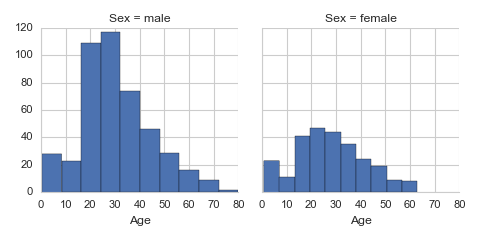

In [9]:
sns.FacetGrid(training_df, col="Sex").map(plt.hist, "Age")

<IPython.core.display.Javascript object>


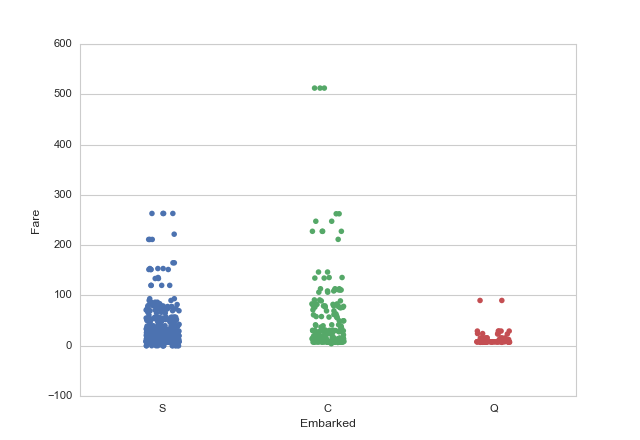

In [11]:
plt.figure()
sns.stripplot(x="Embarked", y="Fare",data=training_df, jitter=True);

### Logictic Regression

In [12]:
y, X = training_df['Survived'], training_df[['Age', 'SibSp', 'Fare']].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)

print(accuracy_score(y_test, lr.predict(X_test)))

0.664804469274


Apparently, there were more men than women on Titanic

In [13]:
classifier = learn.LinearClassifier(n_classes=2, feature_columns=learn.infer_real_valued_columns_from_input(X_train), optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.05))
classifier.fit(X_train, y_train, batch_size=256, steps=500)

print(accuracy_score(classifier.predict(X_test), y_test))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1811: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


0.675977653631
